In [1]:
import numpy as np
import pandas as pd
import time
import random
import os
import re
import json
import ast
import seaborn as sns
from helper_functions_assignment2 import*

## Read results from parameter tuning

In [2]:
best_configs = 'ALNS_smac_results.txt'
smac_runhistory = "ALNS_smac/903c5b3b64e8024ab7d4ada6b66e86f8/0/runhistory.json"

In [3]:
# read in the file with the best configurations
with open(best_configs, 'r') as file:
    file_content = file.read()

# Extract configurations using regular expressions
config_pattern = r"Configuration\(values=\{([^}]*)\}\)"
config_values = re.findall(config_pattern, file_content)

# Convert configurations to a list of dictionaries
config_dicts = []
for config_val in config_values:
    config_dict = ast.literal_eval('{' + config_val + '}')
    config_dicts.append(config_dict)

# Convert the list of dictionaries to a DataFrame
best_configs = pd.DataFrame(config_dicts)
best_configs["best_result"] = True
best_configs

,iterations_per_phase,min_weight,reaction_factor,best_result
0,19,0.167391,0.257866,True
1,38,0.140308,0.583958,True
2,89,0.067264,0.036799,True
3,78,0.141922,0.823344,True
4,39,0.142060,0.640701,True
5,37,0.080686,0.582704,True


In [4]:
# read in run history and transform to a data table
with open(smac_runhistory) as f:
    d = json.load(f)
print("SMAC3 stats:")
print(d["stats"])

# Extracting data and creating a DataFrame
data = d['data']
configs = d['configs']
config_origins = d['config_origins']


columns = ['Config_ID', 'Instance', 'Budget', 'Seed', 'Cost', 'Time', 'Status', 'Start_Time', 'End_Time', 'Additional Info']
runhistory = pd.DataFrame(data, columns=columns[:])

# Extracting score and runtime from the 'Costs' column
runhistory['score'] = runhistory['Cost'].apply(lambda x: x[0] if isinstance(x, list) and len(x) >= 1 else x)
runhistory['runtime'] = runhistory['Cost'].apply(lambda x: x[1] if isinstance(x, list) and len(x) >= 2 else None)


# Map config IDs to their configurations
runhistory['Config Info'] = runhistory['Config_ID'].map(lambda x: configs[str(x)])
runhistory['Config Origin'] = runhistory['Config_ID'].map(lambda x: config_origins[str(x)])

# Splitting Config Info into separate columns
config_info_columns = ['iterations_per_phase', 'min_weight', 'reaction_factor']
for col in config_info_columns:
    runhistory[col] = runhistory['Config Info'].apply(lambda x: x.get(col))

# make a short version for the instance name
runhistory["Instance_ID"]=runhistory["Instance"].str[4:7]
# Rearranging columns for better visibility
runhistory = runhistory[['Config_ID', 'min_weight', 'reaction_factor', 'iterations_per_phase', 
                   "Instance_ID", 
                   'Instance', 'Budget', 'Seed', 'score', "runtime", 'Time', 
                   'Status', 'Start_Time', 'End_Time']]

SMAC3 stats:
{'submitted': 100, 'finished': 100, 'running': 0}


In [5]:
# merge with best results, so we know which are the best ones
smac_results = pd.merge(runhistory, best_configs, 
                        on = config_info_columns,
                        how = "outer").fillna(False)
# bring it in a long format so we can use facet when plotting
smac_results_long = pd.melt(smac_results, id_vars=['Config_ID', "Instance_ID", "score", "runtime", "best_result"], 
        value_vars=['iterations_per_phase', 'min_weight', 'reaction_factor'])
smac_results_long

,Config_ID,Instance_ID,score,runtime,best_result,variable,value
0,1,058,10296.0,132.523885,False,iterations_per_phase,57.000000
1,1,041,12744.0,240.018525,False,iterations_per_phase,57.000000
2,1,060,24509.0,240.154664,False,iterations_per_phase,57.000000
3,2,041,13504.0,240.114032,False,iterations_per_phase,109.000000
4,2,058,9855.0,133.693744,False,iterations_per_phase,109.000000
...,...,...,...,...,...,...,...
295,33,060,22817.0,240.348516,True,reaction_factor,0.582704
296,33,041,13363.0,240.780290,True,reaction_factor,0.582704
297,33,058,9231.0,134.361791,True,reaction_factor,0.582704
298,34,060,24545.0,240.152191,False,reaction_factor,0.569496


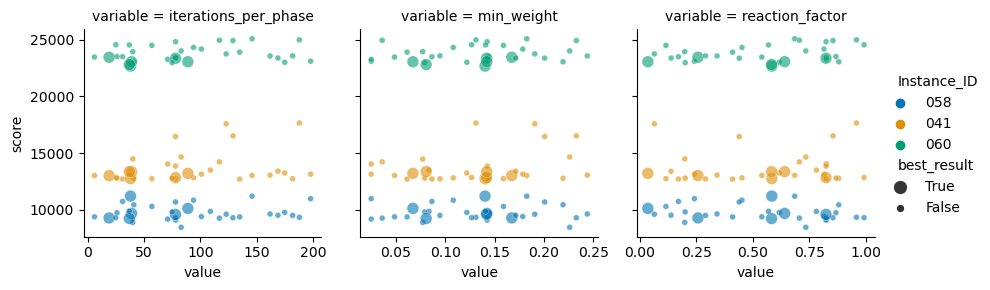

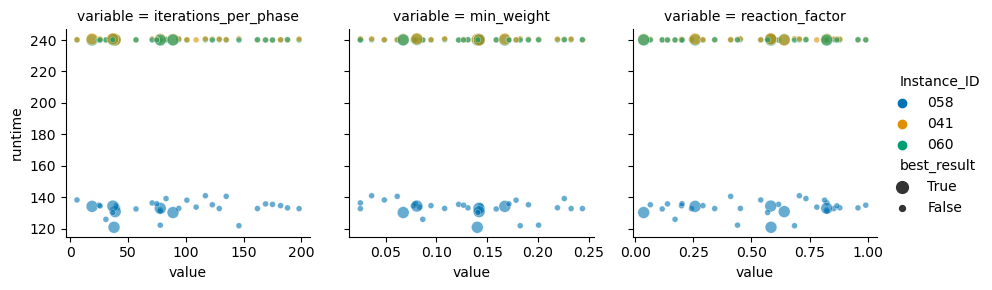

In [6]:
import warnings
warnings.filterwarnings("ignore")
# plot by score
g = sns.relplot(data=smac_results_long, x= "value", y = "score", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False),
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("ALNS_smac_score.png")

# plot by runtime
g = sns.relplot(data=smac_results_long, x= "value", y = "runtime", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False), 
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("ALNS_smac_runtime.png")

In [7]:
smac_results.loc[smac_results["iterations_per_phase"]==39]

,Config_ID,min_weight,reaction_factor,iterations_per_phase,Instance_ID,Instance,Budget,Seed,score,runtime,Time,Status,Start_Time,End_Time,best_result
89,31,0.14206,0.640701,39,060,heur060_n_300_m_12405,209652396,False,23070.0,240.313771,240.416517,1,1.705073e+09,1.705073e+09,True
90,31,0.14206,0.640701,39,041,heur041_n_300_m_17492,209652396,False,13365.0,240.062810,240.161810,1,1.705073e+09,1.705073e+09,True
91,31,0.14206,0.640701,39,058,heur058_n_300_m_4010,209652396,False,9678.0,130.828312,130.930891,1,1.705073e+09,1.705074e+09,True


# Test with best parameter settings

In [9]:
folder_path = "data/test_instances/"
problem_instances = [file.replace('.txt', '') for file in os.listdir(folder_path) if not file == "test.txt"]

In [10]:
test_results = []
iterations_per_phase = 39
for p in problem_instances:
    print(p)
    path = folder_path+p+".txt"
    node_impact_orig, node_degree_orig, plex_assignment, edges_n1, edges_n2, edge_weights, edge_assignment_orig, s, n, m = create_problem_instance(path)
    
    start = time.time()
    plex_assignment = np.random.choice(10, n)
    number_of_phases = round(4000 / iterations_per_phase)
    repair_solution(node_impact_orig, node_degree_orig, plex_assignment, edge_weights, edge_assignment_orig, s)
    
    _, _, _, _, score, traj = ALNS(0.14206, 0.640701, iterations_per_phase, number_of_phases,
        node_impact_orig, node_degree_orig, edge_assignment_orig, edge_weights, plex_assignment, s, trajectory = True)
    
    test_results.append({"Instance": p,
                         "baseline": sum(node_impact_orig)/2,
                         "score": score, 
                         "runtime": time.time()-start,
                        "trajectory": traj})
pd.DataFrame(test_results)

heur001_n_10_m_31
heur002_n_100_m_3274
heur003_n_120_m_2588
heur004_n_140_m_3014
heur005_n_160_m_4015
heur006_n_180_m_6067
heur007_n_200_m_6731
heur008_n_250_m_1045
heur009_n_250_m_1450
heur010_n_250_m_4507
heur011_n_250_m_6574
heur012_n_250_m_20035
time_limit
heur013_n_250_m_22395
time_limit
heur014_n_300_m_14191
heur015_n_300_m_15035
time_limit
heur016_n_300_m_15456
time_limit
heur017_n_300_m_15641
time_limit
heur018_n_300_m_25919
time_limit
heur019_n_300_m_28765
time_limit
heur020_n_320_m_5905
heur021_n_320_m_13507
heur022_n_322_m_14226
time_limit
heur023_n_329_m_16183
time_limit
heur024_n_329_m_27115
time_limit
heur025_n_329_m_32168
time_limit
heur026_n_330_m_1370
heur027_n_330_m_2256
heur028_n_330_m_3253
heur029_n_330_m_4329
heur030_n_330_m_5613
heur031_n_330_m_7270
heur032_n_330_m_9770
heur033_n_330_m_13861
heur034_n_345_m_6830
heur035_n_345_m_17798
time_limit
heur036_n_347_m_17983
time_limit
heur037_n_347_m_31752
time_limit
heur038_n_361_m_7987
heur039_n_361_m_13593
time_limit


,Instance,baseline,score,runtime,trajectory
0,heur001_n_10_m_31,85.0,34.0,2.302694,"[85.0, 84.0, 83.0, 83.0, 80.0, 77.0, 75.0, 75...."
1,heur002_n_100_m_3274,9157.0,2112.0,151.808363,"[9157.0, 9157.0, 9146.0, 9073.0, 9065.0, 8762...."
2,heur003_n_120_m_2588,7682.0,4419.0,65.783081,"[7682.0, 7682.0, 7682.0, 7682.0, 7682.0, 7678...."
3,heur004_n_140_m_3014,8803.0,6202.0,41.059500,"[8803.0, 8803.0, 8803.0, 8803.0, 8801.0, 8801...."
4,heur005_n_160_m_4015,12461.0,8628.0,54.851973,"[12461.0, 12430.0, 12430.0, 12430.0, 12425.0, ..."
5,heur006_n_180_m_6067,16996.0,11623.0,121.955451,"[16996.0, 16890.0, 16887.0, 16885.0, 16885.0, ..."
6,heur007_n_200_m_6731,20919.0,14060.0,129.527270,"[20919.0, 20910.0, 20876.0, 20844.0, 20795.0, ..."
7,heur008_n_250_m_1045,8433.0,2509.0,87.882454,"[8433.0, 8428.0, 8428.0, 8408.0, 8408.0, 8407...."
8,heur009_n_250_m_1450,11780.0,3725.0,97.264495,"[11780.0, 11744.0, 11744.0, 11744.0, 11744.0, ..."
9,heur010_n_250_m_4507,16559.0,8541.0,114.776011,"[16559.0, 16559.0, 16533.0, 16533.0, 16505.0, ..."


In [11]:
alns_results = pd.DataFrame(test_results)
alns_results["instance_ID"] = alns_results["Instance"].str[4:7]
alns_results

,Instance,baseline,score,runtime,trajectory,instance_ID
0,heur001_n_10_m_31,85.0,34.0,2.302694,"[85.0, 84.0, 83.0, 83.0, 80.0, 77.0, 75.0, 75....",001
1,heur002_n_100_m_3274,9157.0,2112.0,151.808363,"[9157.0, 9157.0, 9146.0, 9073.0, 9065.0, 8762....",002
2,heur003_n_120_m_2588,7682.0,4419.0,65.783081,"[7682.0, 7682.0, 7682.0, 7682.0, 7682.0, 7678....",003
3,heur004_n_140_m_3014,8803.0,6202.0,41.059500,"[8803.0, 8803.0, 8803.0, 8803.0, 8801.0, 8801....",004
4,heur005_n_160_m_4015,12461.0,8628.0,54.851973,"[12461.0, 12430.0, 12430.0, 12430.0, 12425.0, ...",005
5,heur006_n_180_m_6067,16996.0,11623.0,121.955451,"[16996.0, 16890.0, 16887.0, 16885.0, 16885.0, ...",006
6,heur007_n_200_m_6731,20919.0,14060.0,129.527270,"[20919.0, 20910.0, 20876.0, 20844.0, 20795.0, ...",007
7,heur008_n_250_m_1045,8433.0,2509.0,87.882454,"[8433.0, 8428.0, 8428.0, 8408.0, 8408.0, 8407....",008
8,heur009_n_250_m_1450,11780.0,3725.0,97.264495,"[11780.0, 11744.0, 11744.0, 11744.0, 11744.0, ...",009
9,heur010_n_250_m_4507,16559.0,8541.0,114.776011,"[16559.0, 16559.0, 16533.0, 16533.0, 16505.0, ...",010


### write results for signifficance testing

In [12]:
alns_results.to_csv("ALNS_test_results.csv", sep=';', columns=["instance_ID", "baseline", "score", "runtime"],
                  header=True, index=False)

### make some more pretty plots

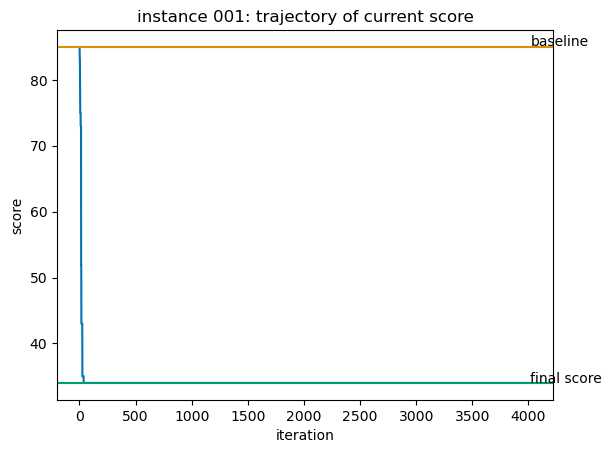

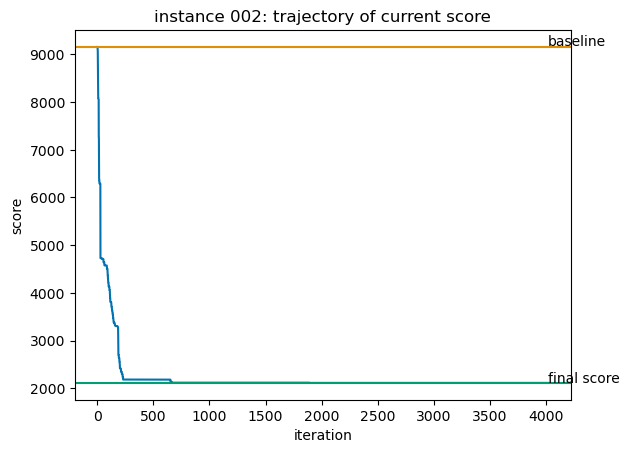

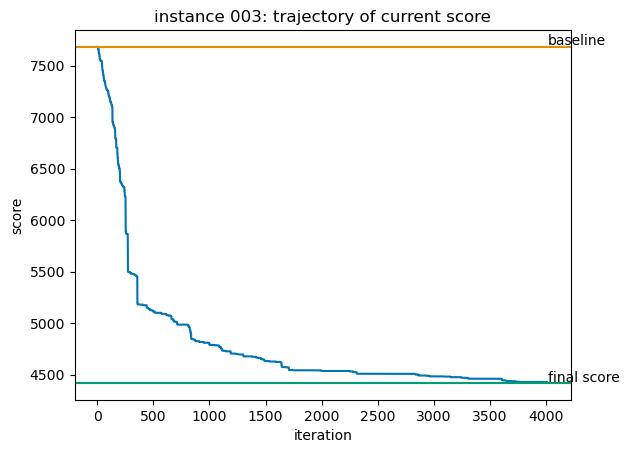

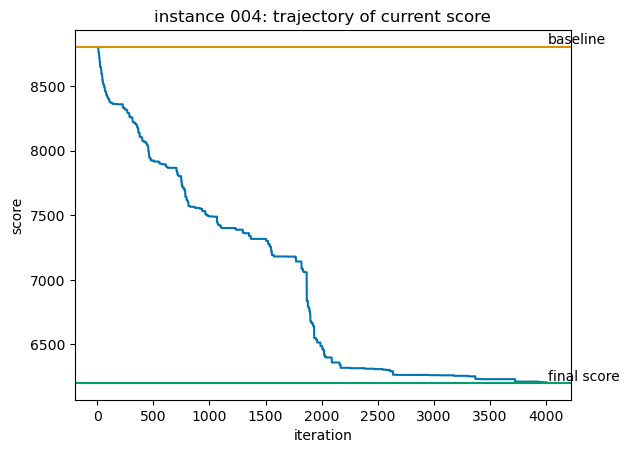

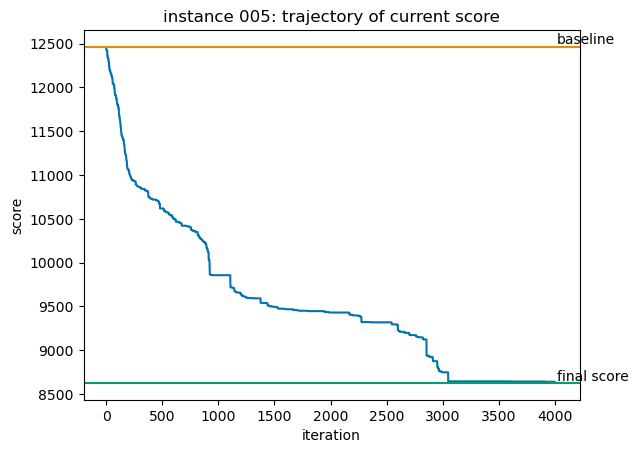

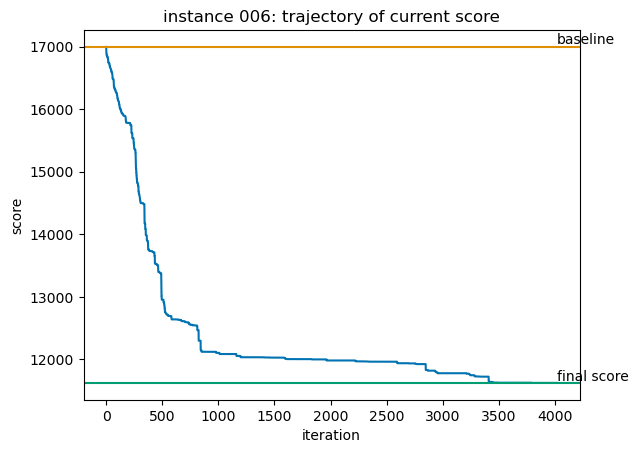

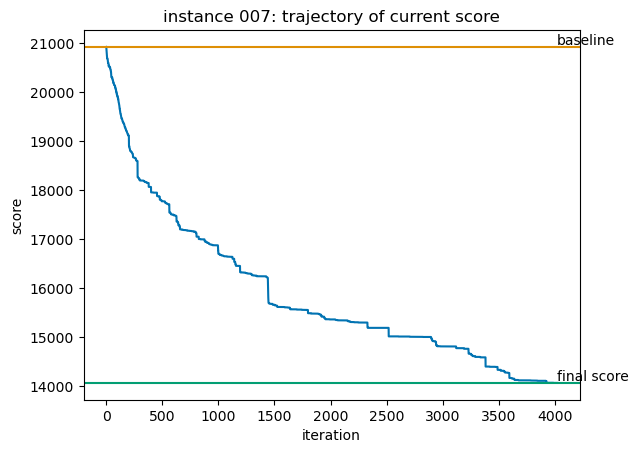

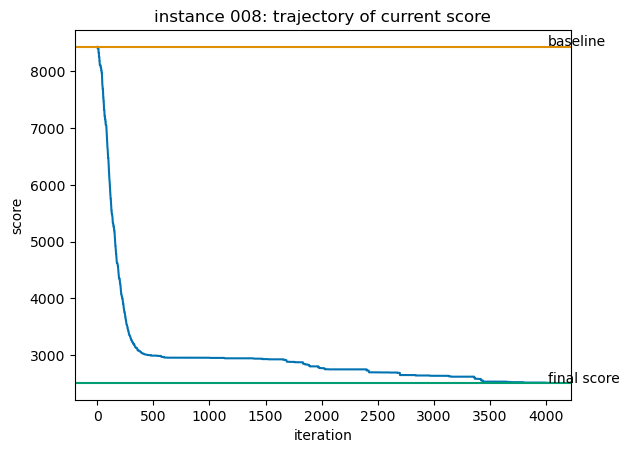

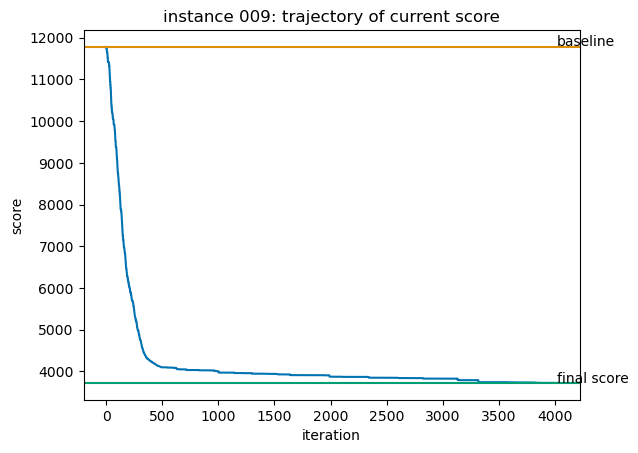

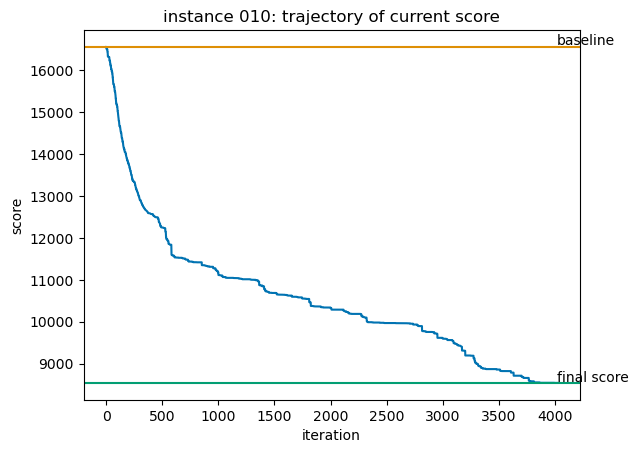

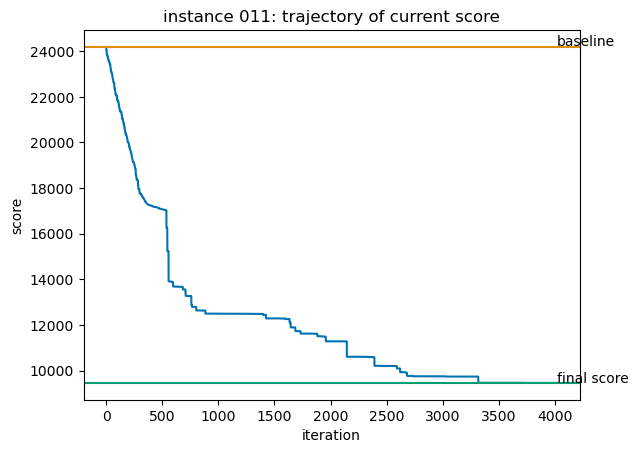

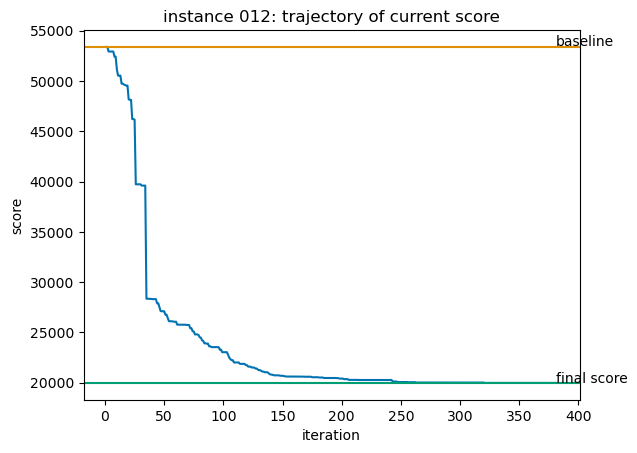

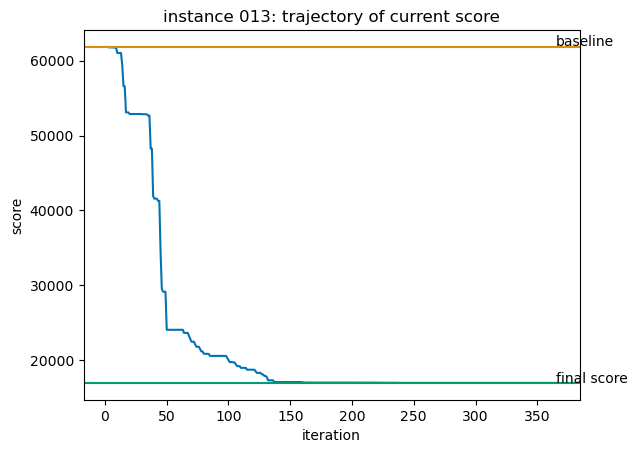

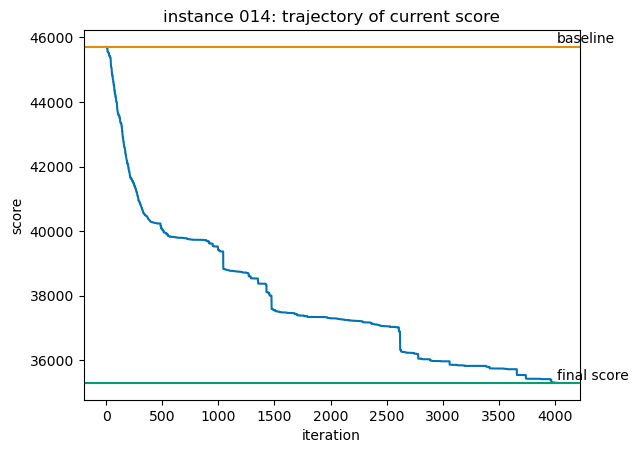

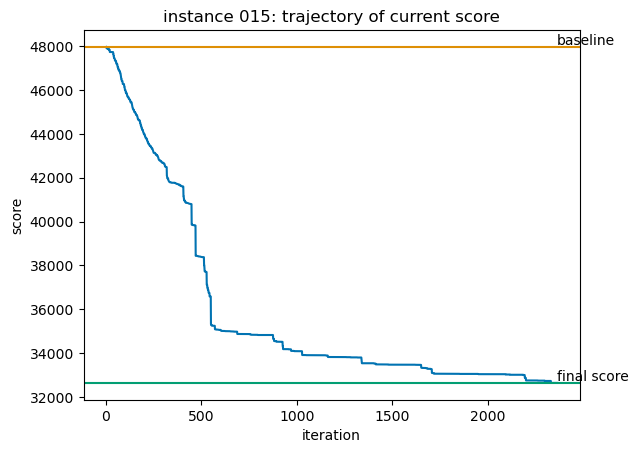

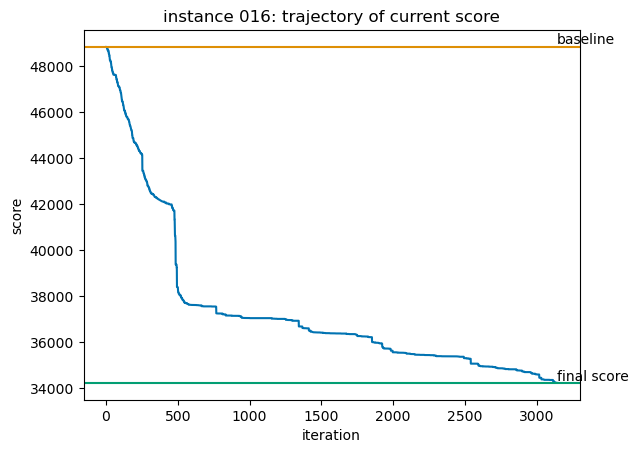

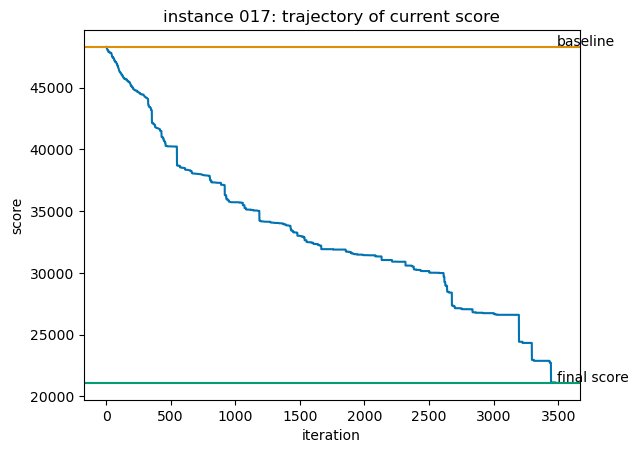

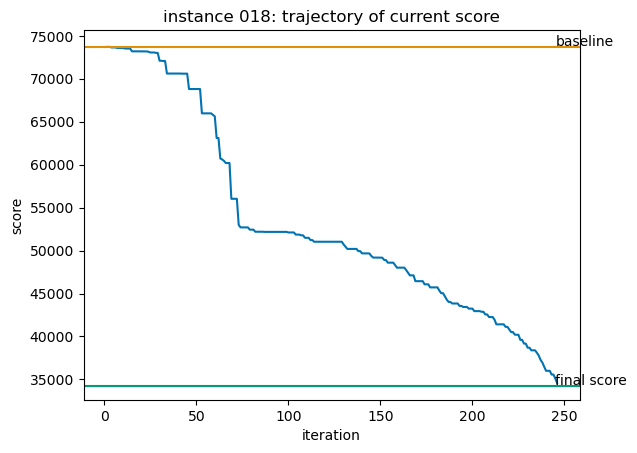

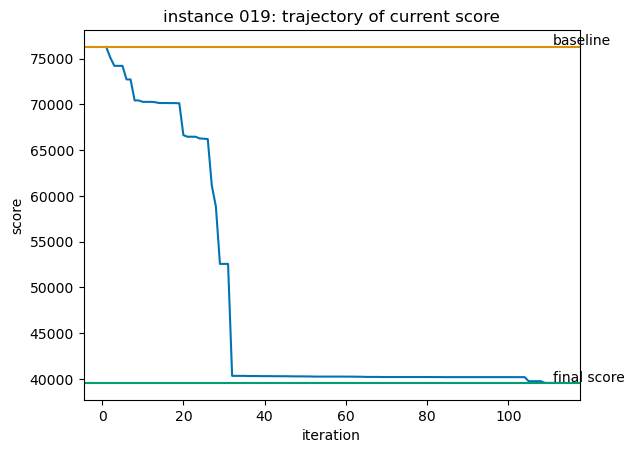

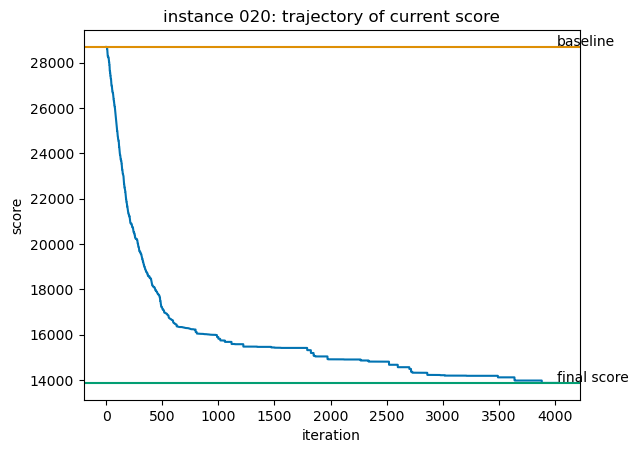

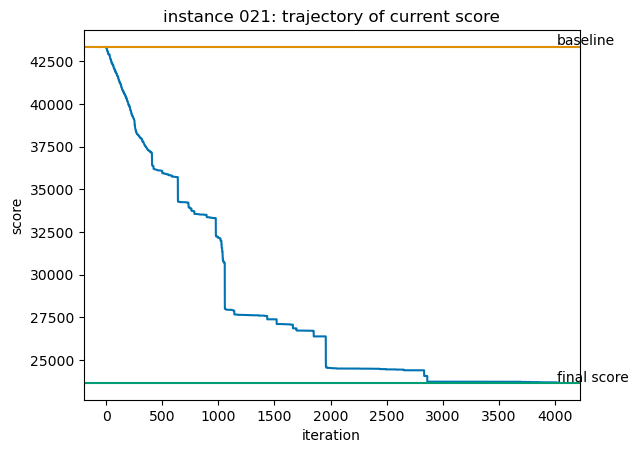

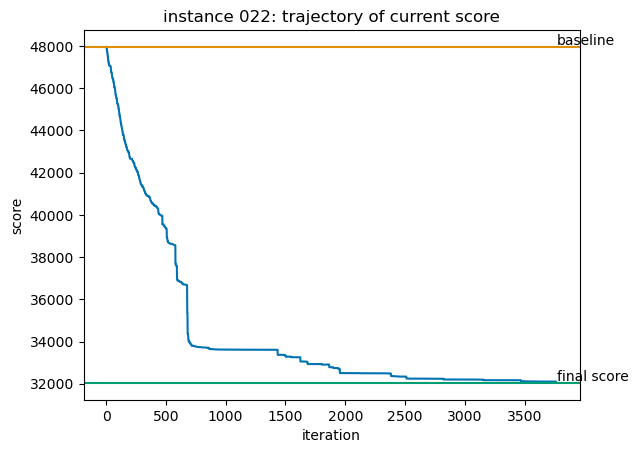

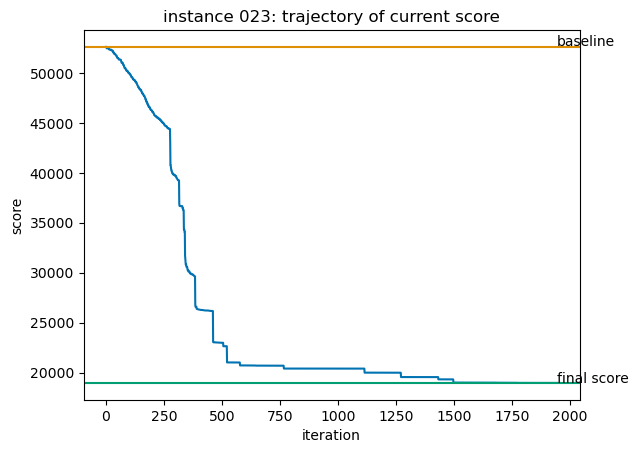

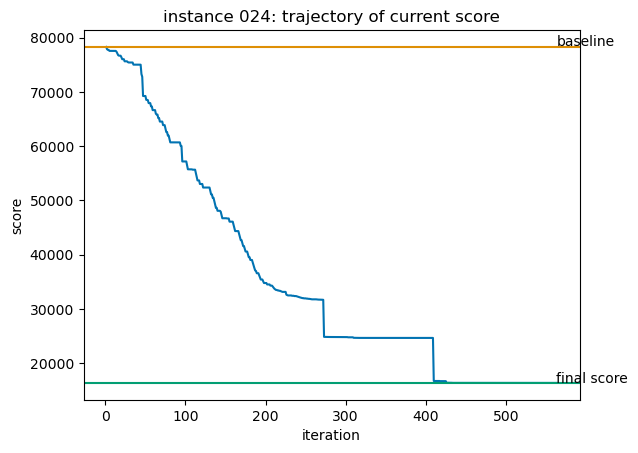

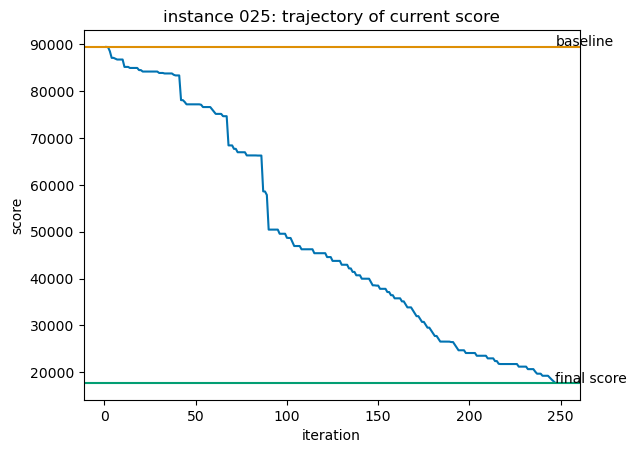

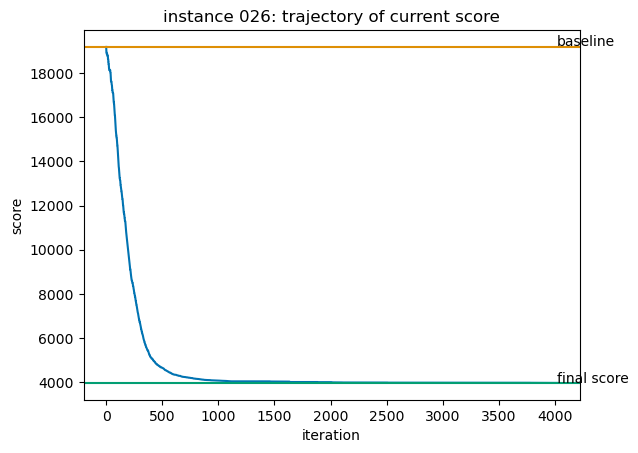

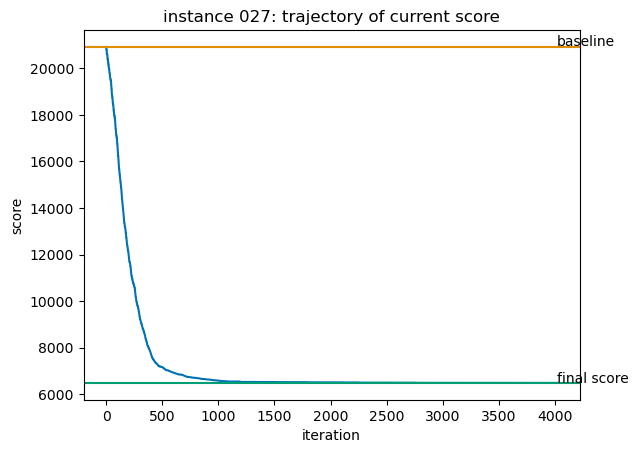

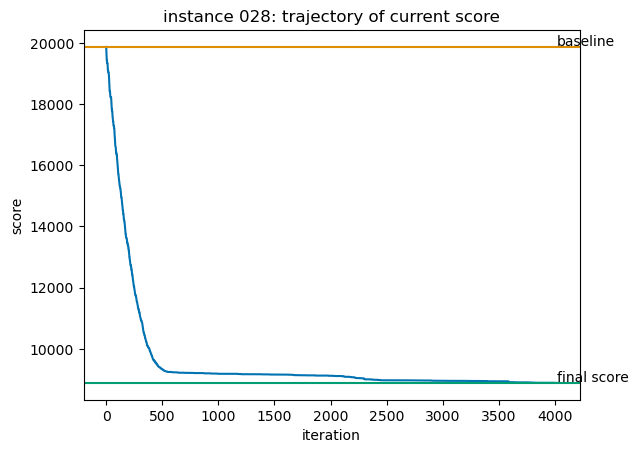

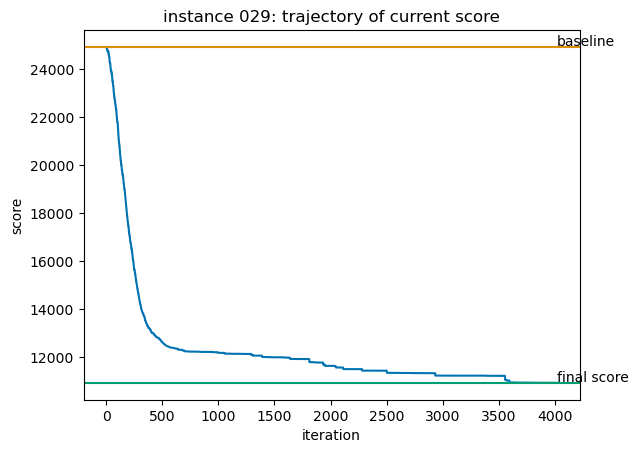

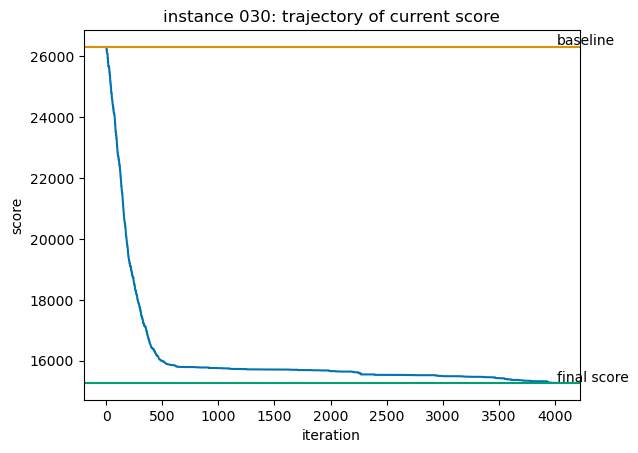

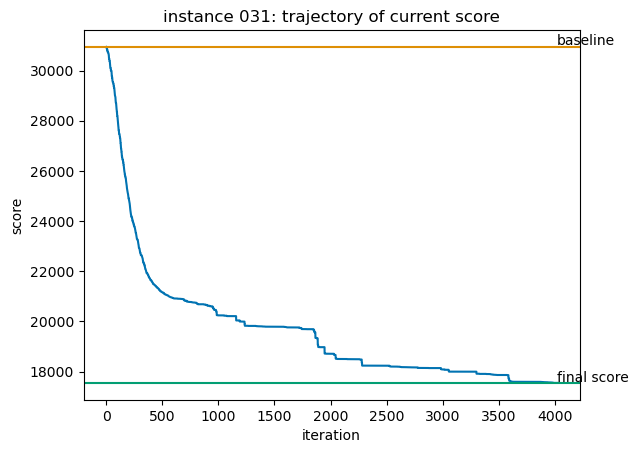

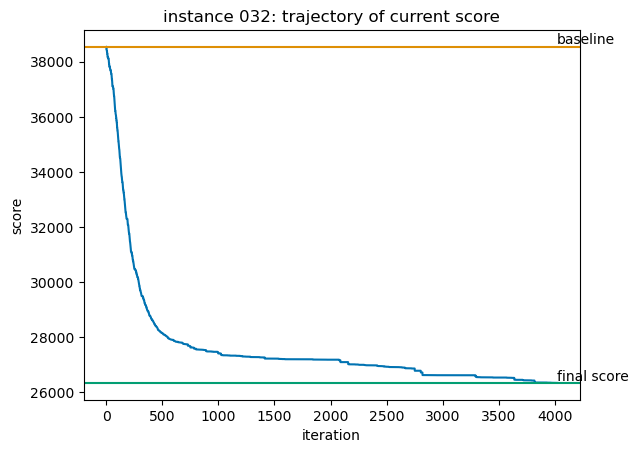

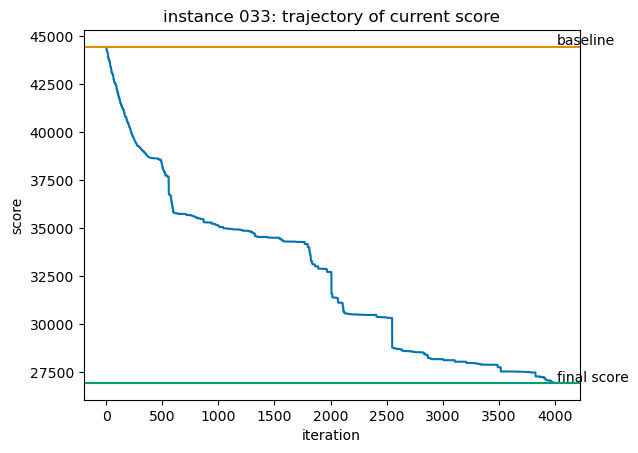

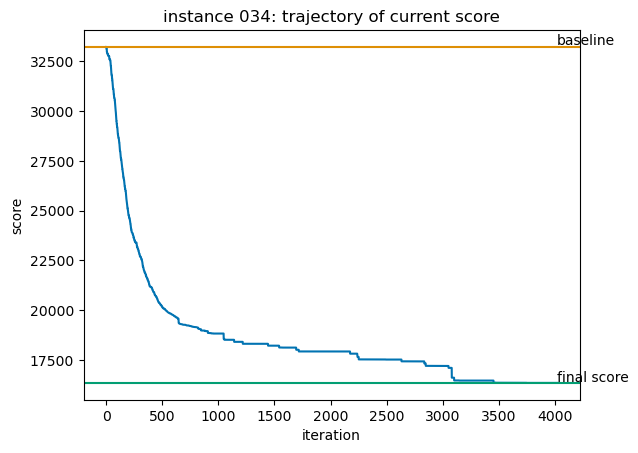

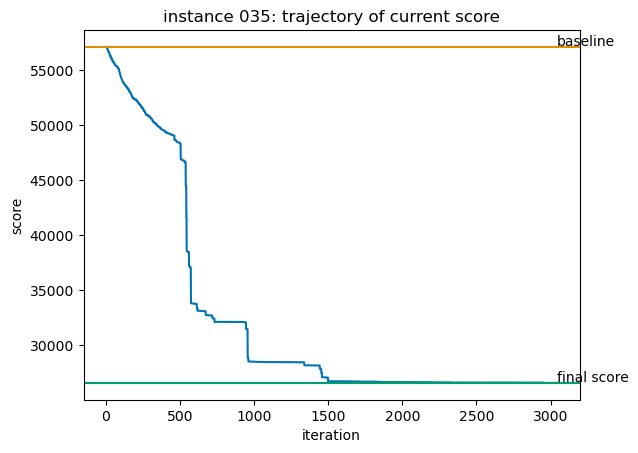

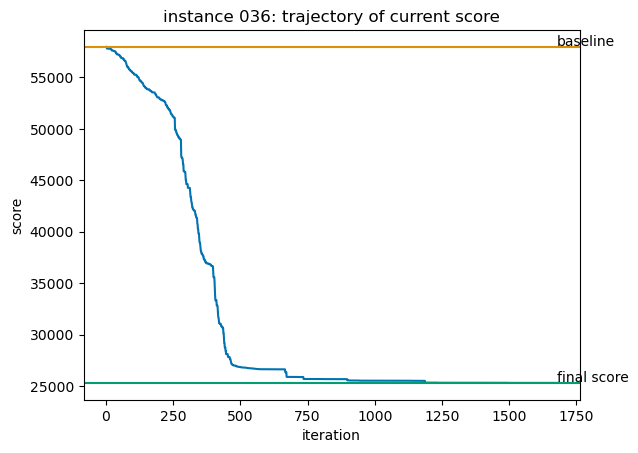

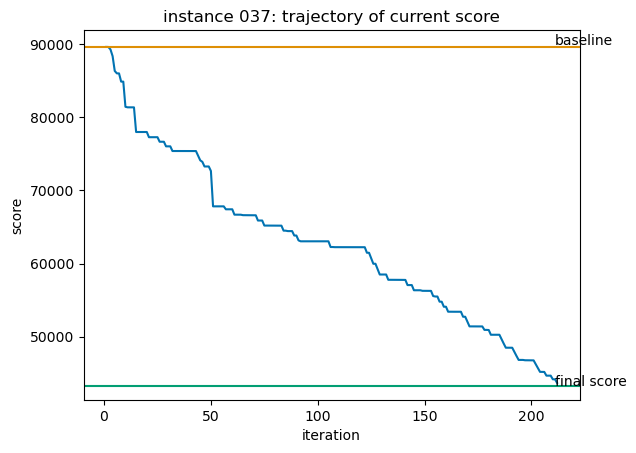

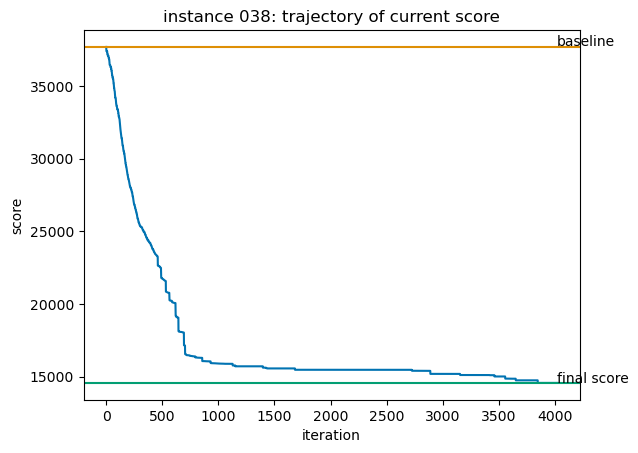

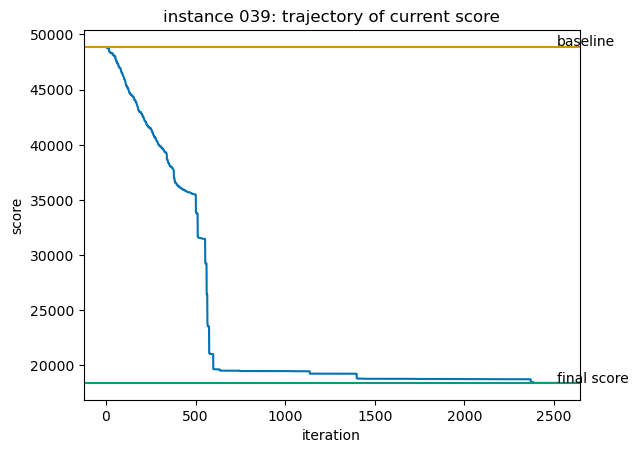

In [13]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
for inst_id in alns_results["instance_ID"]:
    baseline = alns_results["baseline"].loc[alns_results["instance_ID"]==inst_id].values[0]
    trajectory = alns_results["trajectory"].loc[alns_results["instance_ID"]==inst_id].values[0]
    final_score = alns_results["score"].loc[alns_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set(xlabel='iteration', ylabel='score')
    g.set_title("instance "+inst_id+': trajectory of current score')
    
    plt.show()

### pick 2 interesting instances for the report

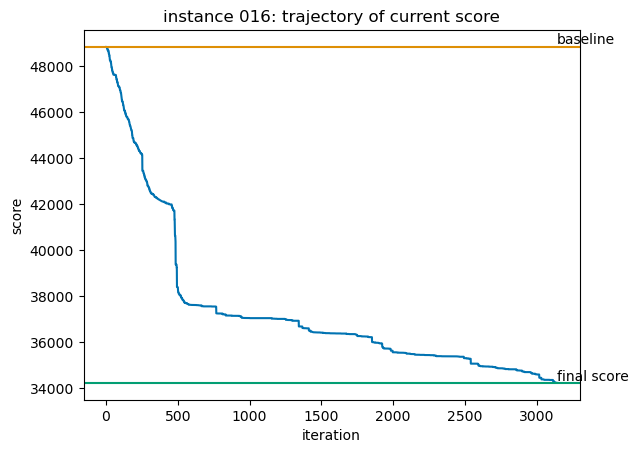

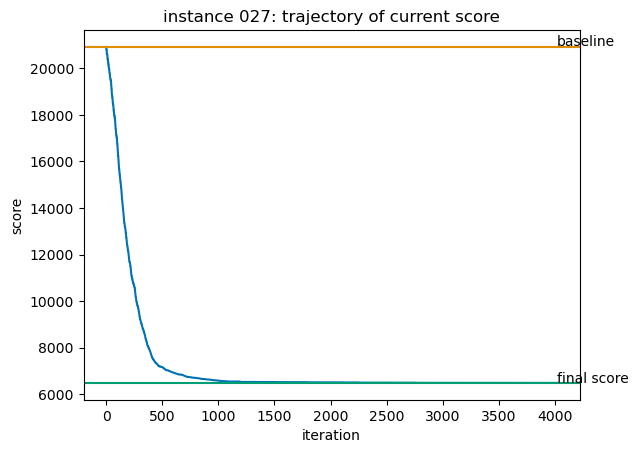

In [14]:
for inst_id in ["016", "027"]:
    baseline = alns_results["baseline"].loc[alns_results["instance_ID"]==inst_id].values[0]
    trajectory = alns_results["trajectory"].loc[alns_results["instance_ID"]==inst_id].values[0]
    final_score = alns_results["score"].loc[alns_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set_title("instance "+inst_id+': trajectory of current score')
    g.set(xlabel='iteration', ylabel='score')
    #
    plt.savefig("ALNS_"+inst_id+".png")
    plt.show()